In [1]:
##Setting up the python environment
import pandas as pd
import os 
import re
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import string
%matplotlib inline 
import textwrap

##Setting up BQ API
from google.cloud import bigquery

# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


##Setting up Google sdk environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jupyter/.config/gcloud/application_default_credentials.json'
## Connect to the right GCP project
os.environ['GCLOUD_PROJECT'] = 'som-nero-egyang-starr' 
%load_ext google.cloud.bigquery
client=bigquery.Client()

project_id = "som-rit-phi-starr-prod"
# dataset_id = "starr_omop_cdm5_deid_1pcent_latest"
dataset_id = "starr_omop_cdm5_deid_latest"
work_project_id = 'som-nero-egyang-starr' 
work_dataset_id = 'ilies_explore'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
fold_num = 2
query="""
(SELECT a.* EXCEPT (PAD, Smoking_status), 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_smok` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_cases_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id
WHERE a.person_id NOT IN (
SELECT *
FROM `{work_project_id}.{work_dataset_id}.321052_ids`))
UNION ALL
(SELECT a.* EXCEPT (PAD, Smoking_status), 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_smok` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_controls_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [3]:
df_ids = pd.read_csv("/home/jupyter/PAD_npj/random_forest/cv/person_ids/testids_fold{fold_num}.csv".format_map({'fold_num': fold_num}))
df_ids = df_ids.drop_duplicates(subset=['test_person_id'])
df_ids.head()

df_test = df.loc[df['person_id'].isin(df_ids['test_person_id'])].drop_duplicates(subset=['person_id'])
len(df_test)

sort_mapping = df_ids.reset_index().set_index('test_person_id')
sort_mapping

df_test['person_id_num'] = df_test['person_id'].map(sort_mapping['index'])
df_test

df_test = df_test.sort_values('person_id_num')
df_test

df_test = df_test.drop(columns=['person_id_num'])
df_test

df_test = df_test.reset_index().drop(columns=['index'])
df_test


,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status,label
0,30293742,70,0.0,Caucasian,0,0,0,0,0,0,32.396878,Ever,1
1,31679702,73,1.0,Caucasian,0,1,0,1,1,1,52.905410,Ever,0
2,30832159,55,0.0,Caucasian,1,0,0,1,0,1,27.271397,Ever,0
3,31818753,89,0.0,Black,1,1,1,1,1,1,35.099286,Ever,0
4,31927032,51,1.0,Hispanic,0,1,0,0,0,0,26.326980,Ever,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567,31725922,65,1.0,Caucasian,1,0,0,1,1,1,32.563814,Ever,0
2568,30558398,84,0.0,Caucasian,1,1,0,1,1,1,28.020176,Current,0
2569,30578811,55,0.0,Black,0,0,0,1,0,1,32.970034,Ever,0
2570,31678128,54,1.0,Caucasian,0,0,0,0,0,0,21.928382,Never,0


In [4]:
df_test.isnull().sum().sum()

1

In [5]:
df_test[df_test.isna().any(axis=1)]


,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status,label
451,31878326,57,1.0,Black,0,0,0,0,0,0,NaN,Never,0


In [6]:
df_test = df_test.fillna(30)

In [7]:
df_test = df_test.drop("person_id",axis = 1)
df_test["Female"] = df_test["Female"].astype("category")
df_test["Race"] = df_test["Race"].astype("category")
df_test["CVA"] = df_test["CVA"].astype("category")
df_test["CAD"] = df_test["CAD"].astype("category")
df_test["HF"] = df_test["HF"].astype("category")
df_test["HTN"] = df_test["HTN"].astype("category")
df_test["Diab"] = df_test["Diab"].astype("category")
df_test["HLD"] = df_test["HLD"].astype("category")
df_test["new_Smoking_status"] = df_test["new_Smoking_status"].astype("category")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_test["Race"])
list(le.classes_)
df_test["Race"] = le.transform(df_test["Race"])

le = preprocessing.LabelEncoder()
le.fit(df_test["new_Smoking_status"])
list(le.classes_)
df_test["new_Smoking_status"] = le.transform(df_test["new_Smoking_status"])

X_test = df_test.drop("label",axis = 1) 
y_test = df_test.label

In [8]:
sum(df_test['label'])/len(df_test)*100

24.72783825816485

In [9]:
fold1 = pd.read_csv("data_5.csv")
fold2 = pd.read_csv("data_3.csv")
fold3 = pd.read_csv("data_4.csv")
fold4 = pd.read_csv("data_1.csv")

In [10]:
df_train = pd.concat([fold1, fold2, fold3, fold4]) 
df_train = df_train.drop("person_id",axis = 1)
df_train["Female"] = df_train["Female"].astype("category")
df_train["Race"] = df_train["Race"].astype("category")
df_train["CVA"] = df_train["CVA"].astype("category")
df_train["CAD"] = df_train["CAD"].astype("category")
df_train["HF"] = df_train["HF"].astype("category")
df_train["HTN"] = df_train["HTN"].astype("category")
df_train["Diab"] = df_train["Diab"].astype("category")
df_train["HLD"] = df_train["HLD"].astype("category")
df_train["new_Smoking_status"] = df_train["new_Smoking_status"].astype("category")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train["Race"])
list(le.classes_)
df_train["Race"] = le.transform(df_train["Race"])

le = preprocessing.LabelEncoder()
le.fit(df_train["new_Smoking_status"])
list(le.classes_)
df_train["new_Smoking_status"] = le.transform(df_train["new_Smoking_status"])
df_train = df_train.reset_index().drop(columns=['index'])
df_train = df_train.dropna()

X_train = df_train.drop("label",axis = 1) 
y_train = df_train.label

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [11]:
import pandas as pd
import numpy as np
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
logistic_regression = LogisticRegression()

In [13]:
logistic_regression.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [14]:
y_pred = logistic_regression.predict_proba(X_test)[:,1]
y_pred

array([0.01158021, 0.13601437, 0.06298227, ..., 0.03142198, 0.02159642,
       0.2226033 ])

In [15]:
np.mean(y_pred)

0.1225778933446284

In [16]:
np.mean(y_test)

0.24727838258164853

In [17]:
# logistic_regression.importance

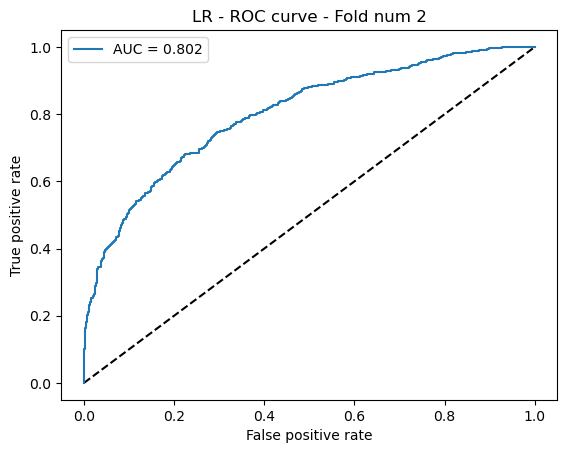

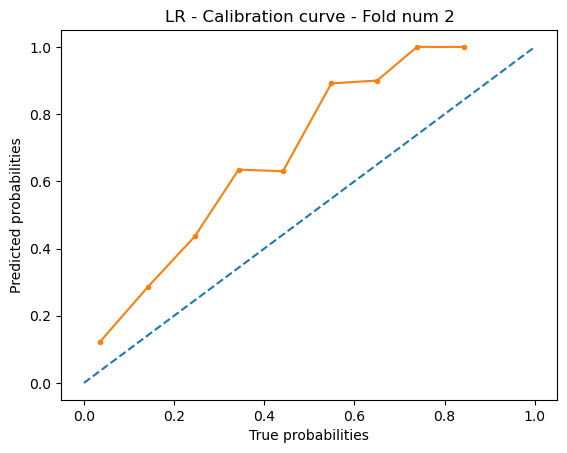

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve


fpr, tpr, thresholds = roc_curve(y_test,y_pred)
auc = auc(fpr, tpr)
auc

fold_num_print = 'Fold_num_2'
fold_title = 'Fold num 2'

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR - ROC curve - ' + str(fold_title))
plt.legend(loc='best')
plt.savefig('PAD_LR_auc_curve_'+str(fold_num_print)+'.jpeg')
plt.show()

# reliability diagram
fop, mpv = calibration_curve(y_test, y_pred, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.xlabel('True probabilities')
plt.ylabel('Predicted probabilities')
plt.title('LR - Calibration curve - '+ str(fold_title))
plt.savefig('PAD_LR_calibration_'+fold_num_print+'.jpeg')
plt.show()


In [19]:
cm

NameError: name 'cm' is not defined

In [20]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print("optimal_threshold = ", optimal_threshold)

cm=confusion_matrix(y_test, y_pred>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

cm,TP,TN,FP,FN,auc,TNR,TPR

print("AUC = ", auc)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
# y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_true = y_test

auc_delong, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc_delong,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc_delong)
# print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

d = {'auc': auc, 'specificity': TNR, 'sensitivity': TPR}
df = pd.DataFrame(data=d, index = [0], dtype=np.float64)
df.to_csv('auc_specificity_sensitivity_fold2.csv', index=False)

optimal_threshold =  0.10691041890142851
AUC =  0.8018413119184988
Specificity =  0.6792452830188679
Sensitivity =  0.7753099173553719
AUC: 0.801841311918499
95% AUC CI: [0.78168976 0.82199286]


In [22]:
auc_std

0.010281591155305405

In [24]:
pd.DataFrame(y_pred, columns = ["test_pred"]).to_csv("lr_testpred_fold2.csv", index=False) 

In [25]:
fold_num = 2
pd.DataFrame(fpr).to_csv("plots/fpr" + str(fold_num) + ".csv")
pd.DataFrame(tpr).to_csv("plots/tpr" + str(fold_num) + ".csv")
pd.DataFrame(fop).to_csv("plots/fop" + str(fold_num) + ".csv")
pd.DataFrame(mpv).to_csv("plots/mpv" + str(fold_num) + ".csv")
pd.DataFrame([auc]).to_csv("plots/auc" + str(fold_num) + ".csv")